In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
# from google.colab import drive
import random
from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import GridSearchCV
import pickle
import pdb
# from scipy.special import softmax


In [80]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict_=pickle.load(fo, encoding='bytes')
    return dict_

In [81]:
### Preparing the training data

## concatanating all the different sets of data
dict_1 = unpickle('data_batch_1')
dict_2 = unpickle('data_batch_2')
dict_3 = unpickle('data_batch_3')
dict_4 = unpickle('data_batch_4')
dict_5 = unpickle('data_batch_5')
keys = list(dict_1.keys())
key = keys[2]
x_1 = dict_1[key]
y_1=dict_1[keys[1]]
x_2 = dict_2[key]
y_2=dict_2[keys[1]]
x_3 = dict_3[key]
y_3=dict_3[keys[1]]
x_4 = dict_4[key]
y_4=dict_4[keys[1]]
x_5 = dict_5[key]
y_5=dict_5[keys[1]]


# Just x_1_train and y_1_train
x1_train_1=x_1
x1_train_1 = x1_train_1 - np.mean(x1_train_1, axis=0) # centering
x1_train_1 = x1_train_1/(np.std(x1_train_1, axis=0)) # normallizing
y1_train = y_1

result = []
for num in y1_train:
    row = [0] * 10  # create a list of 10 zeros
    row[num] = 1  # set the element at the specified position to 1
    result.append(row)
y1_train=result

# Entire batch

images = [x_1, x_2, x_3, x_4, x_5]
labels = [y_1, y_2, y_3, y_4, y_5]
X_train = np.concatenate(images, axis=0)
y_train = np.concatenate(labels, axis=0)
y_train_org=y_train
result = []
for num in y_train:
    row = [0] * 10  # create a list of 10 zeros
    row[num] = 1  # set the element at the specified position to 1
    result.append(row)
y_train=result


## preprocessing
X_train = X_train - np.mean(X_train, axis=0) # centering
X_train_unnormalized=X_train # unnormalized training set
X_train = X_train/(np.std(X_train, axis=0)) # normallizing

### Preparing the test data

dict_test = unpickle('test_batch')
X_test = dict_test[key]
y_test = dict_test[keys[1]]

## preprocessing

# ASK: This is okay rright?
X_test = X_test - np.mean(X_test, axis=0) # centering
X_test_unnormalized=X_test # unnormalized test set
X_test = X_test/(np.std(X_test, axis=0)) # normallizing

In [82]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    
    def __init__(self,leaky_relu_alpha=0, activation_function = lambda z: 1./ (1 + np.exp(-z)),layers=1, units=[64], logistic=False, relu=False, leaky_relu=False, tanh=False, lasso=False, ridge=False , regularization_alpha=0.01):
        
        self.layers = layers
        self.units = units
        self.categories = 10
        self.activation_function = activation_function
        self.relu = relu
        self.tanh = tanh
        self.leaky_relu = leaky_relu
        self.logistic = logistic
        self.leaky_relu_alpha = leaky_relu_alpha
        self.lasso =lasso
        self.ridge = ridge
        self.regularization_alpha = regularization_alpha
        self.params = []
        self.y_test_h = []

        # ASK: We should also include bias as well right?
  

    def fit(self, x, y, optimizer, l1_reg=0, l2_reg=0):
        N,D = x.shape

        def softmax(x):
          # print(x)
          return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

        def xavier_init(shape):
          in_dim = shape[0]
          xavier_stddev = np.sqrt(2.0 / in_dim)
          return np.random.randn(*shape) * xavier_stddev

        # The black_box calculates gradients for different types of activation functions
        def black_box(some_input):
          if self.relu==True:
            y = (some_input > 0) * 1
            return y
          if self.tanh==True:
            return 1-np.tanh(some_input)**2
          if self.leaky_relu==True:
            return (some_input > 0) * self.leaky_relu_alpha
          if self.logistic==True:
            return some_input * (1 - some_input) 

        def gradient(x, y, params):

            # v = weights between input layer and first hidden layer
            # w = weights between first hidden layer and output layer

            gradients=[]
            if self.layers==1:

              # params and feed forward
              v,w = params[0], params[1]
              z=self.activation_function(x@v) # (N x D+1) (D+1 x m+1) = (N, m+1)
              z[:, -1] = 1 # make last column of z one (N x m+1)
              yh=softmax(z@w) # (N, m+1) (m+1, c) = (N, c)

              # gradient calculation
              dw=1/N*(z.T@(yh-y)) # (m+1, N) (N, c) = (m+1, c)
              if self.ridge:
                dw=dw+(self.regularization_alpha/N)*dw
              if self.lasso:
                dw=dw+(self.regularization_alpha/N)*np.sign(dw)

              dv=1//N*(x.T@((yh-y)@w.T*black_box(z))) # (D+1 x N) ( (N x c) (c x m+1) * (N x m+1) ) = (D+1 x m+1) 
              if self.ridge:
                dv=dv+(self.regularization_alpha/N)*dv
              if self.lasso: # Maybe check if this is okay or not
                dv=dv+(self.regularization_alpha/N)*np.sign(dv)

              # gradient
              gradients = [dv, dw]

            elif self.layers==2:
              # m1 number of units in first hidden layer
              # m2 number of units in the second hidden

              # x = (N, D+1)
              v1, v2, w = params[0], params[1], params[2] # (D+1, m1+1) (m1+1 m2+1) (m2+1, c)

              # Feed forward
              z1=self.activation_function(x@v1) # (N x m1+1)
              z1[:, -1] = 1 # make last column of z1 one (N x m1+1)
              z2=self.activation_function(z1@v2) # (N x m2+1)
              z2[:, -1] = 1 # make last column of z1 one (N x m2+1)
              yh=softmax(z2@w) # (N x c)

              # Gradient calculation
              dw=1/N*(z2.T@(yh-y)) # (m2+1 x n) (n x c) = (m2+1 x c)
              if self.ridge:
                dw=dw+(self.regularization_alpha/N)*dw
              if self.lasso:
                dw=dw+(self.regularization_alpha/N)*np.sign(dw)

              dv2=1/N*(z1.T@(((yh-y)@w.T) * (black_box(z2)))) # (m1+1 x N) @ (((N x c) @ (c x m2+1)) * (N x m2+1) ) = (m1+1 x m2+1)
              if self.ridge:
                dv2=dv2+(self.regularization_alpha/N)*dv2
              if self.lasso:
                dv2=dv2+(self.regularization_alpha/N)*np.sign(dv2)

              dv1=1/N*(x.T @ (((((yh-y)@w.T) * (black_box(z2))) @ v2.T) * black_box(z1))) # (D+1, N) @ ((((N, c) (c, m2+1) * (N, m2+1)) @ (m2+1, m1+1))*(N, m1+1))
              if self.ridge:
                dv1=dv1+(self.regularization_alpha/N)*dv1
              if self.lasso:
                dv1=dv1+(self.regularization_alpha/N)*np.sign(dv1)

              gradients = [dv1, dv2, dw]

            else: # layers=0 case
              # pdb.set_trace()
              w = params[0]
              yh = softmax(np.dot(x, w)) # y_hat
              dw=x.T@(yh-y) # (D+1, n) (n x c) = (m2+1 x c)
              if self.ridge:
                dw=dw+self.regularization_alpha*dw
              if self.lasso:
                dw=dw+(self.regularization_alpha/N)*np.sign(dw)
              gradients = [dw]
            return gradients

        if self.layers==1:
          M=self.units[0]
          # v = np.random.randn(D, M+1) * .01 # initializing v with bias
          # w = np.random.randn(M+1, self.categories) * .01 # initializing w with bias
          v = xavier_init((D+1, M+1)) * 0.01 # initializing v with bias using xavier init
          w = xavier_init((M+1, self.categories)) * 0.01 # initializing w without bias using xavier init
          params0 = [v, w]
          n = x.shape[0]
          x = np.hstack((x, np.ones((n, 1))))
          self.params = optimizer.run(gradient, x, y, params0)
        elif self.layers==2:
          M=self.units[0]
          M2=self.units[1]
          v1 = np.random.randn(D+1, M+1) * 0.01 # initiallizing v with bias
          v2= np.random.randn(M+1, M2+1)  * 0.01 # initiallizing v2 with bias
          w = np.random.randn(M2+1,self.categories) * 0.01 # initiallizing w with bias
          params0 = [v1, v2, w]
          n = x.shape[0]
          x = np.hstack((x, np.ones((n, 1)))) # (N, D+1)
          self.params = optimizer.run(gradient, x, y, params0)
        else:
          w = np.random.randn(D+1, self.categories) * 0.001 # initiallizing w
          params0 = [w]
          n = x.shape[0]
          x = np.hstack((x, np.ones((n, 1)))) # (N, D+1)
          self.params = optimizer.run(gradient, x, y, params0)

        return self
    
    def predict(self, x):

      def softmax(x):
        return (np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

      yh=[]
      if self.layers==1:
        # pdb.set_trace()
        v, w = self.params[0], self.params[1] # (D+1, m+1) (m+1, c)
        # stacking one at the end of x matrix
        n = x.shape[0]
        x = np.hstack((x, np.ones((n, 1))))
        z = self.activation_function(x @ v) # N x M+1
        yh = softmax(z@w) # (N x m+1) (m+1, c)
        self.y_test_h=yh
      elif self.layers==2:
        v1, v2, w = self.params[0], self.params[1], self.params[2] # (D+1, m+1) (m+1m m2+1) (m2+1, c)
        n = x.shape[0]
        x = np.hstack((x, np.ones((n, 1))))
        z1 = self.activation_function(np.dot(x, v1)) # (N, D+1) (D+1, m1+1)
        z2 = self.activation_function(np.dot(z1, v2)) # (N, m1+1) (m1+1, m2+1)
        yh = softmax(np.dot(z2, w)) # (N, m2+1) (m2+1, c)
        self.y_test_h=yh
      else:
        w = self.params[0]
        n = x.shape[0]
        x = np.hstack((x, np.ones((n, 1)))) # (N, D+1)
        yh = softmax(np.dot(x, w)) # y_hat
        self.y_test_h=yh

      # converting probabilities to categories
      max_indices_list = []
      for row in yh:
          row=list(row)
          max_index = row.index(max(row))
          max_indices_list.append(max_index)
      self.y_test_h=max_indices_list

      return max_indices_list

    def evaluate_acc(self, y_test, yh):
      score_card = []
      count=0
      for predicted_label in yh:
          actual_label=y_test[count]
          if (actual_label == predicted_label):
              score_card.append(1)
          else:
              score_card.append(0)
          count+=1
        
      return np.sum(score_card)/len(y_test)

class GradientDescent:
    
    def __init__(self, activation_function, layers, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.activation_function = activation_function
        self.layers=layers
        self.y_axis=[]
        self.x_axis=[]

    def cost(self, x, y, params):
      def softmax(x):
        return (np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

      def evaluate_acc(y_test, yh):
          score_card = []
          count=0
          for predicted_label in yh:
              actual_label=y_test[count]
              if (actual_label == predicted_label):
                  score_card.append(1)
              else:
                  score_card.append(0)
              count+=1

          return np.sum(score_card)/len(y_test)

      yh=None
      if self.layers==1:
        # pdb.set_trace()
        v, w = params[0], params[1] # (D+1, m+1) (m+1, c)
        z = self.activation_function(x @ v) # N x M+1
        yh = softmax(z@w) # (N x m+1) (m+1, c)
      elif self.layers==2:
        v1, v2, w = params[0], params[1], params[2] # (D+1, m+1) (m+1m m2+1) (m2+1, c)
        z1 = self.activation_function(np.dot(x, v1)) # (N, D+1) (D+1, m1+1)
        z2 = self.activation_function(np.dot(z1, v2)) # (N, m1+1) (m1+1, m2+1)
        yh = softmax(z2@w) # (N, m2+1) (m2+1, c)
      else:
        w = params[0]
        yh = softmax(np.dot(x, w)) # y_hat

      max_indices_list = []
      for row in yh:
          row=list(row)
          max_index = row.index(max(row))
          max_indices_list.append(max_index)

      curr_acc = evaluate_acc(y_test=y, yh=max_indices_list)      
      
      
      return curr_acc

        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        params_curr=params
        t = 1
        # converting probabilities to categories
        max_indices_list = []

        for row in y:
            row=list(row)
            max_index = row.index(max(row))
            max_indices_list.append(max_index)

        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params_curr)
            for p in range(len(params)):
                params_curr[p] -= self.learning_rate * grad[p]
            t += 1
            self.x_axis.append(t)
            norms = np.array([np.linalg.norm(g) for g in grad])
            cost_curr = self.cost(x, max_indices_list, params=params_curr)
            self.y_axis.append(cost_curr)
        plt.plot(self.x_axis, self.y_axis)
        plt.xlabel("Epochs")
        plt.ylabel("Training accuracies")
        plt.show()
        return params_curr

# Task 1

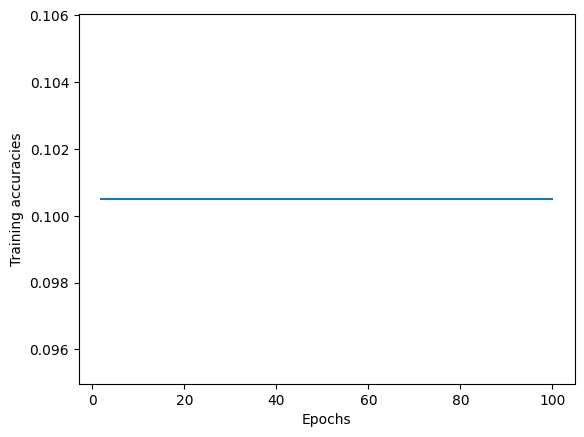

Subpart a: 0.1


In [97]:
## Subpart a

model=MLP(layers=0, units=[], activation_function=logistic, logistic=True)
optimizer = GradientDescent(activation_function=logistic, layers=0, learning_rate=.001, max_iters=100)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart a: {model.evaluate_acc(yh=yh, y_test=y_test)}')

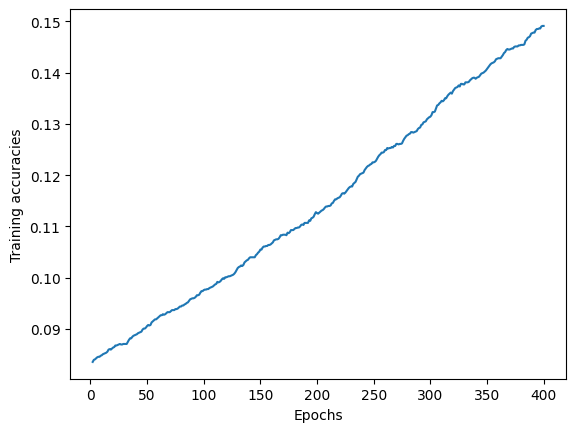

Subpart b: 0.1398


In [85]:
# Subpart b
def relu(x):
    return np.maximum(0, x)

model=MLP(layers=1, units=[256], activation_function=relu, relu=True)
optimizer = GradientDescent(activation_function=relu, layers=1, learning_rate=.001, max_iters=400)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart b: {model.evaluate_acc(yh=yh, y_test=y_test)}')

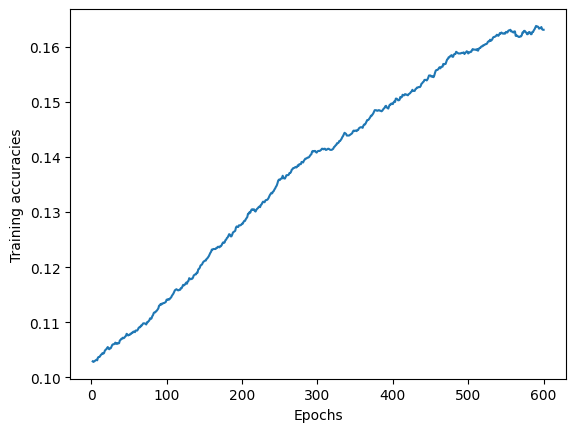

Subpart a: 0.1603


In [86]:
# Subpart c

def relu(x):
    return np.maximum(0, x)

model=MLP(layers=2, units=[256, 256], activation_function=relu, relu=True)
optimizer = GradientDescent(activation_function=relu, layers=2, learning_rate=.001, max_iters=600)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart a: {model.evaluate_acc(yh=yh, y_test=y_test)}')

# Task 2

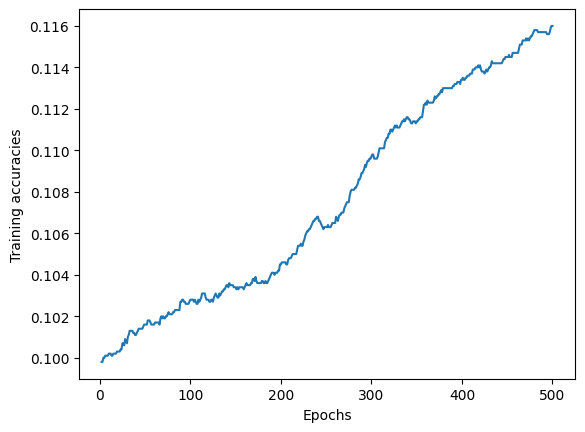

Subpart a accuracy: 0.1133


In [87]:

# Subpart a
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

model=MLP(layers=2, units=[256, 256], activation_function=leaky_relu, leaky_relu=True)
optimizer = GradientDescent(activation_function=leaky_relu, layers=2, learning_rate=.001, max_iters=500)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart a accuracy: {model.evaluate_acc(yh=yh, y_test=y_test)}')

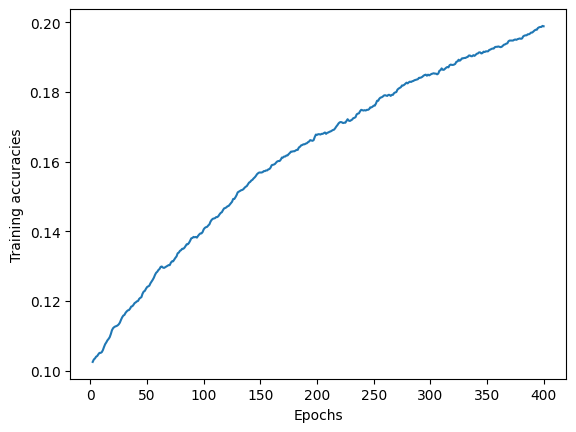

Subpart b accuracy: 0.21


In [89]:
# Subpart b
def tanh(x):
    return np.tanh(x)


model=MLP(layers=2, units=[256, 256], activation_function=tanh, tanh=True)
optimizer = GradientDescent(activation_function=tanh, layers=2, learning_rate=.001, max_iters=400)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)

yh=model.predict(X_test)
print(f'Subpart b accuracy: {model.evaluate_acc(yh=yh, y_test=y_test)}')

# Task 3

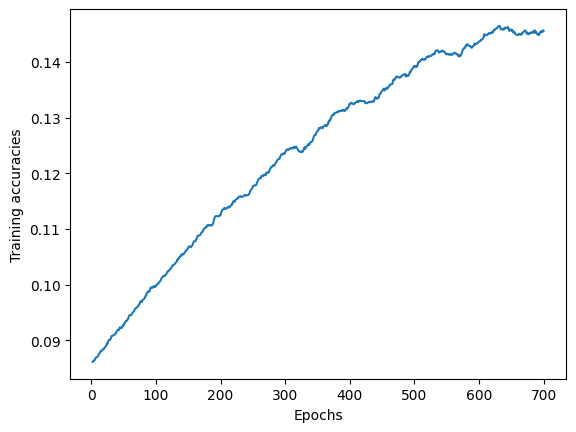

Subpart a accuracy: 0.1488


In [90]:

# subpart a L1 regularization
def relu(x):
    return np.maximum(0, x)

model=MLP(layers=2, units=[256, 256], activation_function=relu, relu=True, lasso=True, regularization_alpha=0.01)
optimizer = GradientDescent(activation_function=relu, layers=2, learning_rate=.001, max_iters=700)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)

yh=model.predict(X_test)
print(f'Subpart a accuracy: {model.evaluate_acc(yh=yh, y_test=y_test)}')

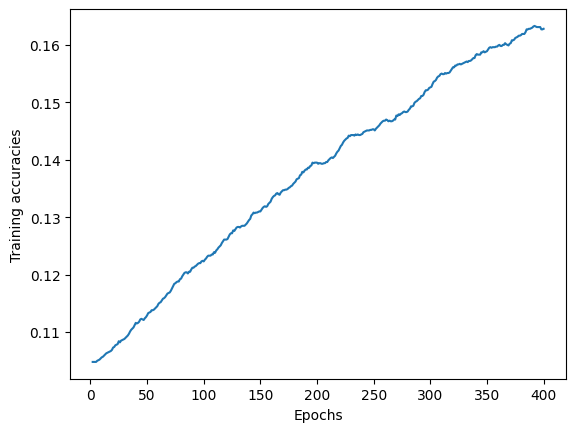

Subpart b accuracy: 0.1633


In [91]:
# subpart b L2 regularization
def relu(x):
    return np.maximum(0, x)

model=MLP(layers=2, units=[256, 256], activation_function=relu, relu=True, ridge=True, regularization_alpha=0.01)
optimizer = GradientDescent(activation_function=relu, layers=2, learning_rate=.001, max_iters=400)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)

yh=model.predict(X_test)
print(f'Subpart b accuracy: {model.evaluate_acc(yh=yh, y_test=y_test)}')

# Task 4

C:\Users\Asus\AppData\Local\Temp\ipykernel_160\1656982751.py:246: RuntimeWarning: overflow encountered in matmul
  yh = softmax(z2@w) # (N, m2+1) (m2+1, c)
C:\Users\Asus\AppData\Local\Temp\ipykernel_160\1656982751.py:221: RuntimeWarning: invalid value encountered in subtract
  return (np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())
C:\Users\Asus\AppData\Local\Temp\ipykernel_160\1656982751.py:91: RuntimeWarning: overflow encountered in matmul
  yh=softmax(z2@w) # (N x c)
C:\Users\Asus\AppData\Local\Temp\ipykernel_160\1656982751.py:30: RuntimeWarning: invalid value encountered in subtract
  return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())


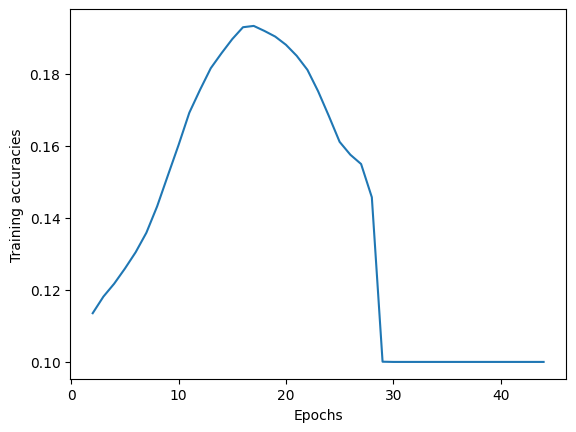

Subpart a accuracy: 0.1


In [92]:

# Subpart a

def relu(x):
    return np.maximum(0, x)

model=MLP(layers=2, units=[256, 256], activation_function=relu, relu=True)
optimizer = GradientDescent(activation_function=relu, layers=2, learning_rate=.001, max_iters=400)
model.fit(x=X_train_unnormalized, y=y_train, optimizer=optimizer)
yh=model.predict(X_test_unnormalized)
print(f'Subpart a accuracy: {model.evaluate_acc(yh=yh, y_test=y_test)}')

# Extra Experiments

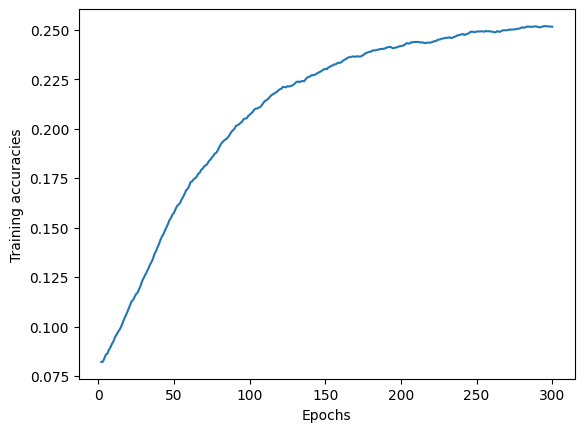

Subpart a accuracy: 0.2502


In [94]:
# Increasing the width of the MLP

model=MLP(layers=2, units=[1000, 1000], activation_function=tanh, tanh=True)
optimizer = GradientDescent(activation_function=tanh, layers=2, learning_rate=.001, max_iters=300)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart a accuracy: {model.evaluate_acc(yh=yh, y_test=y_test)}')

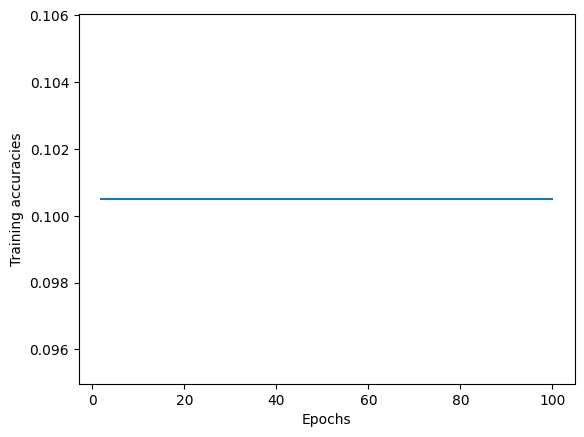

Subpart a: 0.1


In [95]:
# Justification for lower learning rates

# Exploding gradient at learning_rate = 0.01

model=MLP(layers=0, units=[], activation_function=logistic, logistic=True)
optimizer = GradientDescent(activation_function=logistic, layers=0, learning_rate=.01, max_iters=100)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart a: {model.evaluate_acc(yh=yh, y_test=y_test)}')

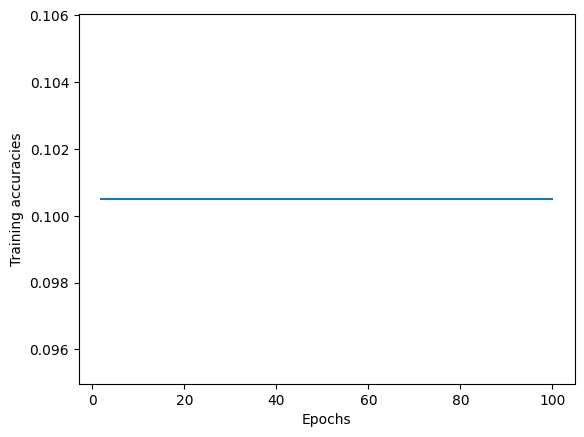

Subpart a: 0.1


In [96]:
# Exploding gradient at learning_rate = 0.1

model=MLP(layers=0, units=[], activation_function=logistic, logistic=True)
optimizer = GradientDescent(activation_function=logistic, layers=0, learning_rate=.1, max_iters=100)
model.fit(x=x1_train_1, y=y1_train, optimizer=optimizer)
yh=model.predict(X_test)
print(f'Subpart a: {model.evaluate_acc(yh=yh, y_test=y_test)}')